In [ ]:
# This is a series of examples using the icanswim/qchem quantum mechanic machine learning repo
# icanswim/qchem utilizes the icanswim/cosmosis data science machine learning repo

In [1]:
import sys # required for relative imports in jupyter lab
sys.path.insert(0, '../') 

from cosmosis.model import FFNet
from cosmosis.dataset import SKDS
from cosmosis.learning import Learn, Selector

from dataset import QM7, QM7b, QM7X, ANI1x, QM9

from torch.optim import Adam
from torch.nn import MSELoss, L1Loss
from torch.optim.lr_scheduler import ReduceLROnPlateau

RDKit WARNING: [12:18:06] Enabling RDKit 2019.09.3 jupyter extensions


CDataset created...
SKDS make_regression created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:02.675608
epoch: 0, lr: 0.01
train loss: 20824.551142939814, val loss: 14140.899609375
test loss: 433.63817138671874
learning time: 0:00:09.297240


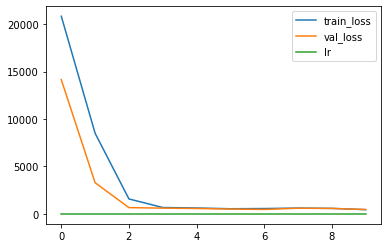

In [2]:
## Example using scikit dataset wrapper SKDS and custom model
model_params = {'D_in': 128, 
                'H': 512, 
                'D_out': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'features': ['X'],
                              'targets': ['y'],
                              'features_dtype': 'float32',
                              'targets_dtype': 'float32',
                              'make': 'make_regression',
                              'transform': [],
                              'target_transform': [],
                              'sk_params': {'n_samples': 10000,
                                            'n_features': 128}}}

metrics_params = {'report_interval': 10}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1}

l = Learn([SKDS], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=256, epochs=10)

CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:00.723529
epoch: 0, lr: 0.01
train loss: 1534.7806010999177, val loss: 1514.9273071289062
test loss: 42.049471855163574
learning time: 0:00:07.115994


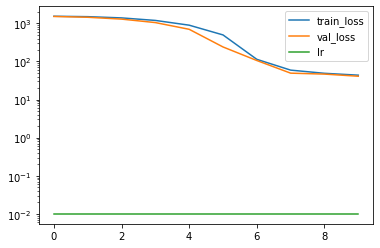

In [3]:
## Example using QM7 dataset and custom model
model_params = {'D_in': 23*23, 
                'H': 2048, 
                'D_out': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'features': ['coulomb'],
                              'targets': ['ae'],
                              'in_file': './data/qm7/qm7.mat',
                              'flatten': True}}

metrics_params = {'report_interval': 10,
                  'log_plot': True}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 3,
                'cooldown': 2}

opt_params = {'lr': 0.01}

l = Learn([QM7], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=256, epochs=10)

CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:00.731227
epoch: 0, lr: 0.01
train loss: 1562.2500770970394, val loss: 1545.6566162109375
test loss: 64.66947364807129
learning time: 0:00:07.153299


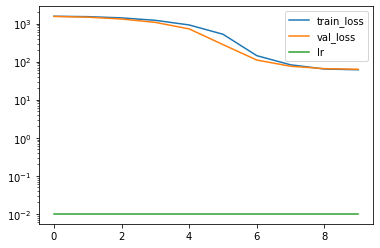

In [4]:
## Example using the QM7b dataset
model_params = {'D_in': 23*23, 
                'H': 2048, 
                'D_out': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'features': ['coulomb'],
                              'targets': ['E'],
                              'in_file': './data/qm7b/qm7b.mat',
                              'flatten': True}}

metrics_params = {'report_interval': 10,
                  'log_plot': True}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 3,
                'cooldown': 2}

opt_params = {'lr': 0.01}

l = Learn([QM7b], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params, 
          batch_size=256, epochs=10)

In [ ]:
## Find the longest molecule in the QM7X dataset

features = ['DIP','HLgap','atC6','atNUM','atPOL','atXYZ','eAT','hDIP',
            'eC','eDFTB+MBD','eEE','eH','eKIN','eKSE','eL','eMBD','eNE', 
            'eNN','ePBE0','ePBE0+MBD','eTS','eX','eXC','eXX','hCHG', 
            'hRAT','hVDIP','hVOL','mC6','mPOL','mTPOL','pbe0FOR', 
            'sMIT','sRMSD','totFOR','vDIP','vEQ','vIQ','vTQ','vdwFOR','vdwR',
            'coulomb'] #(1110,) pad=23

ds_params = {'train_params': {'features': features,
                              'pad': 23,
                              'targets': ['atNUM'],
                              'as_tensor': False,
                              #'embeds': [],
                              'selector': ['opt'],
                              'flatten': True}}

qm7x = QM7X(**ds_params['train_params'])

l, m = 0, 0
for i in qm7x.ds_idx:
    s = qm7x[i]['X'].shape[0]
    if s > l:
        l = s
        m = i
print('longest molecule length: ', l, m)
print(qm7x[m]['X'].shape) 
qm7x[m]


In [2]:
## Example using the QM7X dataset and custom model with embeddings
model_params = {'D_in': 1109,
                'H': 2048, 
                'D_out': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'features': ['DIP','HLgap','atC6','atNUM','atPOL','atXYZ','hDIP',
                                           'eC','eDFTB+MBD','eEE','eH','eKIN','eKSE','eL','eMBD','eNE', 
                                           'eNN','ePBE0','ePBE0+MBD','eTS','eX','eXC','eXX','hCHG', 
                                           'hRAT','hVDIP','hVOL','mC6','mPOL','mTPOL','pbe0FOR', 
                                           'sMIT','sRMSD','totFOR','vDIP','vEQ','vIQ','vTQ','vdwFOR','vdwR',
                                           'coulomb'],
                              'pad': 23,
                              'targets': ['eAT'],
                              #'embeds': [],
                              'selector': ['opt'],
                              'flatten': True}}

metrics_params = {'report_interval': 10,
                  'log_plot': True}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 2}

opt_params = {'lr': 0.01}

l = Learn([QM7X], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=256, epochs=10)

mapping...  <HDF5 file "1000.hdf5" (mode r)>


KeyError: 6

creating QM9 dataset...
molecules scanned:  1
molecules created:  1
molecules scanned:  1001
molecules created:  1001
total molecules scanned:  2000
total uncharacterized molecules removed:  53
total molecules created:  1947
CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:00.628995
epoch: 0, lr: 0.01
train loss: 306.5719787597656, val loss: 311.2166748046875
learning time: 0:00:06.618931
epoch: 10, lr: 0.01
train loss: 281.5822448730469, val loss: 282.75885009765625
learning time: 0:00:12.634732
epoch: 20, lr: 0.01
train loss: 179.5981689453125, val loss: 176.58367919921875
test loss: 19.023639678955078
learning time: 0:00:18.344656


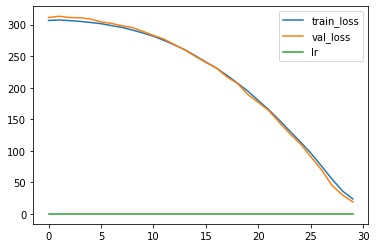

In [6]:
## Example using the QM9 dataset filter
model_params = {'D_in': 14, 
                'H': 256, 
                'D_out': 1, 
                'model_name': 'funnel',
               # 'embed_params': [('hybridization',9,16,0,True),('chirality',9,16,0,True)]
               }

rdkit_features = ['atom_types','atomic_numbers','aromatic','chirality','degree',
                  'charge','n_hs','n_rads','hybridization','edge_indices','edge_attr',
                  'rdmol_block','n_atoms']

qm9_features = ['A','B','C','mu','alpha','homo','lumo', 
                'gap','r2','zpve','U0','U','H','G','Cv',
                'smile','n_atoms']


ds_params = {'train_params': {'n': 2000,
                              'db': 'qm9',
                              'n_conformers': 1,
                              'features': ['A','B','C','mu','alpha','homo','lumo', 
                                           'gap','r2','zpve','U','H','G','Cv'],
                              #'embeds': ['hybridization','chirality'],
                              'targets': ['U0'],
                              'pad': 23,
                              'pad_feats': ['mulliken','coulomb','aromatic','degree',
                                            'charge','n_hs','n_rads'],
                              'as_tensor': True,
                              #'filter_on': ('n_atoms','<','18'),
                              'use_pickle': False,
                              'flatten': True}}


metrics_params = {'report_interval': 10,
                  'log_plot': True}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15),
                 #'subset': .1
                }

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 2}

opt_params = {'lr': 0.01}

l = Learn([QM9], FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          batch_size=256, epochs=30)

molecules loaded:  1000
molecules loaded:  2000
molecules loaded:  3000
molecules loaded:  3114
CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:04.069467
epoch: 0, lr: 0.01
train loss: 564.0651604147519, val loss: 529.5058797200521
learning time: 0:00:14.388594
epoch: 7, lr: 0.01
train loss: 48.80809739056755, val loss: 51.70656967163086
learning time: 0:00:18.777116
epoch: 10, lr: 0.01
train loss: 44.25129699707031, val loss: 43.073567708333336
learning time: 0:00:29.088694
epoch: 17, lr: 0.01
train loss: 37.52554792516372, val loss: 42.79740905761719
learning time: 0:00:33.553579
epoch: 20, lr: 0.005
train loss: 42.09105323342716, val loss: 49.96151987711588
learning time: 0:00:43.822815
epoch: 27, lr: 0.005
train loss: 30.629151849185718, val loss: 35.1195920308431
learning time: 0:00:48.224590
epoch: 30, lr: 0.005
train loss: 28.058291154749252, val loss: 34.45256233215332
learning time: 0:00:58.898032
epoch: 37, lr: 0.005
trai

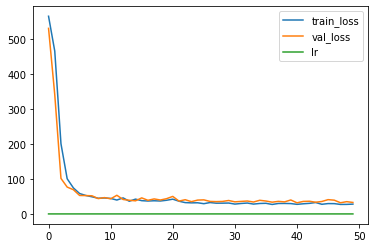

In [3]:
## Example using ANI1x dataset with filter and embeddings with a custom model
model_params = {'D_in': 63*63+63, 
                'H': 8192, 
                'D_out': 1, 
                'model_name': 'funnel'
               }

ds_params = {'train_params': {'features': ['distance','atomic_numbers'],
                              'targets': ['wb97x_dz.energy'],
                              'pad_feats': ['distance','atomic_numbers'],
                              'pad': 63, #length of the longest molecule in the dataset
                              'flatten': True,
                              'criterion': ['wb97x_dz.energy'],
                              'conformation': 'max',
                              'in_file': './data/ani1x/ani1x-release.h5'}}

metrics_params = {'report_interval': 20}

crit_params = {'reduction': 'sum'}
sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}
sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 5}
opt_params = {'lr': 0.01}

l = Learn([ANI1x], FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          batch_size=128, epochs=10)